In [1]:
#1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report

# Modeller
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
try:
    import xgboost as xgb
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("XGBoost kütüphanesi bulunamadı, listeden çıkarılıyor.")

# Optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Cross-validation stratejisi (global tanımlama)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Tüm kütüphaneler başarıyla yüklendi!")
print(f"Cross-validation: {cv.get_n_splits()}-Fold Stratified KFold hazır")

Tüm kütüphaneler başarıyla yüklendi!
Cross-validation: 5-Fold Stratified KFold hazır


C:\Users\Meta-4\anaconda3\envs\tan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. VERİ YÜKLEME VE HAZIRLIK
df_benign = pd.read_csv('krono_benign.csv')
df_malware = pd.read_csv('krono_malware.csv')
df = pd.concat([df_benign, df_malware], ignore_index=True)

if 'apk_name' in df.columns:
    df = df.drop(columns=['apk_name'])

df = df.replace([np.inf, -np.inf], np.nan).dropna()

X = df.drop(columns=['label'])
y = df['label']

# ---- SPLIT ÖNCE (Data Leakage Önleme) ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- SCALING SADECE TRAIN İLE FIT (Data Leakage Önleme) ----
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")

Training set: 55164 samples
Test set: 13791 samples
Number of features: 50


In [3]:
# 3. BASELINE MODELLERİN TANIMLANMASI (Optuna Öncesi)
baseline_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=1),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=1),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

if xgboost_available:
    baseline_models["XGBoost"] = xgb.XGBClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=6, 
        eval_metric='logloss', random_state=42, n_jobs=1
    )

# 3. BASELINE MODELLERİN EĞİTİMİ VE TESTİ
baseline_results = []

print("=" * 70)
print("BASELINE MODELLER (Optuna Öncesi)")
print("=" * 70)
print(f"{'Model':<20} | {'Acc':<8} | {'F1-Score':<8} | {'Precision':<8} | {'Recall':<8}")
print("-" * 70)

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0
    
    print(f"{name:<20} | {acc:.4f}   | {f1:.4f}   | {prec:.4f}   | {rec:.4f}")
    
    baseline_results.append({
        "Model": name,
        "Type": "Baseline",
        "Accuracy": acc,
        "F1_Score": f1,
        "Precision": prec,
        "Recall": rec,
        "AUC": auc
    })

print("=" * 70)

BASELINE MODELLER (Optuna Öncesi)
Model                | Acc      | F1-Score | Precision | Recall  
----------------------------------------------------------------------
Random Forest        | 0.9648   | 0.9670   | 0.9629   | 0.9712
SVM (RBF)            | 0.9276   | 0.9310   | 0.9411   | 0.9211
KNN                  | 0.9603   | 0.9629   | 0.9544   | 0.9716
Decision Tree        | 0.9473   | 0.9506   | 0.9448   | 0.9565
Gradient Boosting    | 0.9476   | 0.9508   | 0.9474   | 0.9542
XGBoost              | 0.9751   | 0.9765   | 0.9777   | 0.9753


In [4]:
# 4 XGBoost Optimizasyonu
if xgboost_available:
    print("\n[1/6] XGBoost optimizasyonu yapılıyor...")
    
    def objective_xgb(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "random_state": 42,
            "n_jobs": 1
        }
        
        model = xgb.XGBClassifier(**params)
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
        return scores.mean()
    
    study_xgb = optuna.create_study(direction="maximize")
    study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=False)
    
    optimized_xgb = xgb.XGBClassifier(
        **study_xgb.best_params,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=1
    )
    optimized_xgb.fit(X_train, y_train)
    print(f"   Best CV F1-Score: {study_xgb.best_value:.4f}")
    print(f"   Best params: {study_xgb.best_params}")
else:
    optimized_xgb = None


[1/6] XGBoost optimizasyonu yapılıyor...
   Best CV F1-Score: 0.9857
   Best params: {'n_estimators': 280, 'max_depth': 8, 'learning_rate': 0.11994090742740315, 'subsample': 0.8993180090990576, 'colsample_bytree': 0.7156473186837502, 'min_child_weight': 2}


In [5]:
# 5. OPTUNA İLE HİPERPARAMETRE OPTİMİZASYONU

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Sadece önemli mesajları göster

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "=" * 70)
print("HİPERPARAMETRE OPTİMİZASYONU BAŞLIYOR (Optuna)")
print("=" * 70)


HİPERPARAMETRE OPTİMİZASYONU BAŞLIYOR (Optuna)


In [6]:
# 7 Random Forest Optimizasyonu
print("\n[3/6] Random Forest optimizasyonu yapılıyor...")

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 8, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "n_jobs": 1,
        "random_state": 42
    }
    
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    return scores.mean()

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=False)

optimized_rf = RandomForestClassifier(
    **study_rf.best_params, n_jobs=1, random_state=42
)
optimized_rf.fit(X_train, y_train)
print(f"   Best CV F1-Score: {study_rf.best_value:.4f}")
print(f"   Best params: {study_rf.best_params}")


[3/6] Random Forest optimizasyonu yapılıyor...
   Best CV F1-Score: 0.9822
   Best params: {'n_estimators': 138, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [7]:
# 8 KNN Optimizasyonu
print("\n[4/6] KNN optimizasyonu yapılıyor...")

def objective_knn(trial):
    params = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 15),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "p": trial.suggest_int("p", 1, 2),
        "n_jobs": 1
    }
    
    model = KNeighborsClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    return scores.mean()

study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_knn, n_trials=30, show_progress_bar=False)

optimized_knn = KNeighborsClassifier(**study_knn.best_params, n_jobs=1)
optimized_knn.fit(X_train, y_train)
print(f"   Best CV F1-Score: {study_knn.best_value:.4f}")
print(f"   Best params: {study_knn.best_params}")


[4/6] KNN optimizasyonu yapılıyor...
   Best CV F1-Score: 0.9734
   Best params: {'n_neighbors': 4, 'weights': 'distance', 'p': 1}


In [8]:
# 9 Decision Tree Optimizasyonu
print("\n[5/6] Decision Tree optimizasyonu yapılıyor...")

def objective_dt(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 8, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42
    }
    
    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    return scores.mean()

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_dt, n_trials=30, show_progress_bar=False)

optimized_dt = DecisionTreeClassifier(
    **study_dt.best_params, random_state=42
)
optimized_dt.fit(X_train, y_train)
print(f"   Best CV F1-Score: {study_dt.best_value:.4f}")
print(f"   Best params: {study_dt.best_params}")


[5/6] Decision Tree optimizasyonu yapılıyor...
   Best CV F1-Score: 0.9624
   Best params: {'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': None}


In [9]:
# 10 Gradient Boosting Optimizasyonu
print("\n[6/6] Gradient Boosting optimizasyonu yapılıyor...")

def objective_gb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "random_state": 42
    }
    
    model = GradientBoostingClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1")
    return scores.mean()

study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(objective_gb, n_trials=30, show_progress_bar=False)

optimized_gb = GradientBoostingClassifier(
    **study_gb.best_params, random_state=42
)
optimized_gb.fit(X_train, y_train)
print(f"   Best CV F1-Score: {study_gb.best_value:.4f}")
print(f"   Best params: {study_gb.best_params}")

print("=" * 70)
print("OPTİMİZASYON TAMAMLANDI")
print("=" * 70)


[6/6] Gradient Boosting optimizasyonu yapılıyor...
   Best CV F1-Score: 0.9838
   Best params: {'n_estimators': 163, 'learning_rate': 0.1988536056651631, 'max_depth': 7, 'subsample': 0.8407717821596636, 'min_samples_split': 7}
OPTİMİZASYON TAMAMLANDI


In [10]:
# 11. OPTİMİZE EDİLMİŞ MODELLERİN TESTİ
optimized_results = []

print("\n" + "=" * 70)
print("OPTİMİZE EDİLMİŞ MODELLER (Optuna Sonrası)")
print("=" * 70)
print(f"{'Model':<20} | {'Acc':<8} | {'F1-Score':<8} | {'Precision':<8} | {'Recall':<8}")
print("-" * 70)

optimized_models = {
    "Random Forest": optimized_rf,
    "KNN": optimized_knn,
    "Decision Tree": optimized_dt,
    "Gradient Boosting": optimized_gb
}

if xgboost_available and optimized_xgb is not None:
    optimized_models["XGBoost"] = optimized_xgb

for name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0
    
    print(f"{name:<20} | {acc:.4f}   | {f1:.4f}   | {prec:.4f}   | {rec:.4f}")
    
    optimized_results.append({
        "Model": name,
        "Type": "Optimized",
        "Accuracy": acc,
        "F1_Score": f1,
        "Precision": prec,
        "Recall": rec,
        "AUC": auc
    })

print("=" * 70)


OPTİMİZE EDİLMİŞ MODELLER (Optuna Sonrası)
Model                | Acc      | F1-Score | Precision | Recall  
----------------------------------------------------------------------
Random Forest        | 0.9822   | 0.9832   | 0.9841   | 0.9822
KNN                  | 0.9752   | 0.9768   | 0.9707   | 0.9829
Decision Tree        | 0.9653   | 0.9673   | 0.9676   | 0.9669
Gradient Boosting    | 0.9835   | 0.9845   | 0.9827   | 0.9863
XGBoost              | 0.9869   | 0.9877   | 0.9872   | 0.9882


In [11]:
# 12. BİREYSEL MODELLERİN KARŞILAŞTIRMASI (Baseline vs Optimized)
all_results = baseline_results + optimized_results
comparison_df = pd.DataFrame(all_results)

print("\n" + "=" * 90)
print("BİREYSEL MODEL KARŞILAŞTIRMASI: BASELINE vs OPTIMIZED")
print("=" * 90)

# Her model için yan yana karşılaştırma
for model_name in comparison_df['Model'].unique():
    model_data = comparison_df[comparison_df['Model'] == model_name]
    baseline = model_data[model_data['Type'] == 'Baseline'].iloc[0] if len(model_data[model_data['Type'] == 'Baseline']) > 0 else None
    optimized = model_data[model_data['Type'] == 'Optimized'].iloc[0] if len(model_data[model_data['Type'] == 'Optimized']) > 0 else None
    
    if baseline is not None and optimized is not None:
        improvement = ((optimized['F1_Score'] - baseline['F1_Score']) / baseline['F1_Score']) * 100
        print(f"\n{model_name}:")
        print(f"  Baseline:  Acc={baseline['Accuracy']:.4f} | F1={baseline['F1_Score']:.4f} | Prec={baseline['Precision']:.4f} | Rec={baseline['Recall']:.4f}")
        print(f"  Optimized: Acc={optimized['Accuracy']:.4f} | F1={optimized['F1_Score']:.4f} | Prec={optimized['Precision']:.4f} | Rec={optimized['Recall']:.4f}")
        print(f"  → F1-Score Improvement: {improvement:+.2f}%")

print("\n" + "=" * 90)


BİREYSEL MODEL KARŞILAŞTIRMASI: BASELINE vs OPTIMIZED

Random Forest:
  Baseline:  Acc=0.9648 | F1=0.9670 | Prec=0.9629 | Rec=0.9712
  Optimized: Acc=0.9822 | F1=0.9832 | Prec=0.9841 | Rec=0.9822
  → F1-Score Improvement: +1.67%

KNN:
  Baseline:  Acc=0.9603 | F1=0.9629 | Prec=0.9544 | Rec=0.9716
  Optimized: Acc=0.9752 | F1=0.9768 | Prec=0.9707 | Rec=0.9829
  → F1-Score Improvement: +1.44%

Decision Tree:
  Baseline:  Acc=0.9473 | F1=0.9506 | Prec=0.9448 | Rec=0.9565
  Optimized: Acc=0.9653 | F1=0.9673 | Prec=0.9676 | Rec=0.9669
  → F1-Score Improvement: +1.75%

Gradient Boosting:
  Baseline:  Acc=0.9476 | F1=0.9508 | Prec=0.9474 | Rec=0.9542
  Optimized: Acc=0.9835 | F1=0.9845 | Prec=0.9827 | Rec=0.9863
  → F1-Score Improvement: +3.55%

XGBoost:
  Baseline:  Acc=0.9751 | F1=0.9765 | Prec=0.9777 | Rec=0.9753
  Optimized: Acc=0.9869 | F1=0.9877 | Prec=0.9872 | Rec=0.9882
  → F1-Score Improvement: +1.15%




🕐 TEMPORAL ANALYSIS: AndroZoo Dataset Loading

📁 Loading AndroZoo dataset...
   Benign samples: 9,000
   Malware samples: 9,000
   Total samples: 18,000

🔧 Fixing labels...
   Original label values: ['0'
 '0026D10F4C75594D80237CA59CC406E165EFF3FE780E608641C5E65F9EE03F37C.apk' 1]
   Fixed label values: [0 1]
   Label distribution:
label
1    9000
0    8999
Name: count, dtype: int64

🧹 Cleaning data...
   After cleaning: 17,999 samples

⚙️ Applying scaling (using Krono-fitted scaler)...

✅ AndroZoo Dataset Ready!
   Samples: 17,999
   Features: 50
   Benign: 8,999 (50.0%)
   Malware: 9,000 (50.0%)

🚀 TEMPORAL INFERENCE: Testing Krono-trained models on AndroZoo

Model                | Dataset         | Acc     | F1      | Prec    | Recall  | AUC    
----------------------------------------------------------------------------------------------------


C:\Users\Meta-4\AppData\Local\Temp\ipykernel_18644\2936126479.py:63: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df_androzoo[col].fillna(df_androzoo[col].median(), inplace=True)
C:\Users\Meta-4\AppData\Local\Temp\ipykernel_18644\2936126479.py:63: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series throug

Random Forest        | Krono Test      | 0.98216 | 0.98317 | 0.98412 | 0.98223 | 0.99808
Random Forest        | AndroZoo        | 0.86499 | 0.84526 | 0.99001 | 0.73744 | 0.88994
                     | Degradation     |   11.9% |   14.0% |   -0.6% |   24.9% |   10.8%
----------------------------------------------------------------------------------------------------
XGBoost              | Krono Test      | 0.98695 | 0.98771 | 0.98717 | 0.98825 | 0.99860
XGBoost              | AndroZoo        | 0.87988 | 0.86460 | 0.99067 | 0.76700 | 0.92980
                     | Degradation     |   10.8% |   12.5% |   -0.4% |   22.4% |    6.9%
----------------------------------------------------------------------------------------------------
KNN                  | Krono Test      | 0.97520 | 0.97678 | 0.97071 | 0.98292 | 0.99037
KNN                  | AndroZoo        | 0.86121 | 0.84266 | 0.97280 | 0.74322 | 0.88400
                     | Degradation     |   11.7% |   13.7% |   -0.2% |   24.4% |   10.

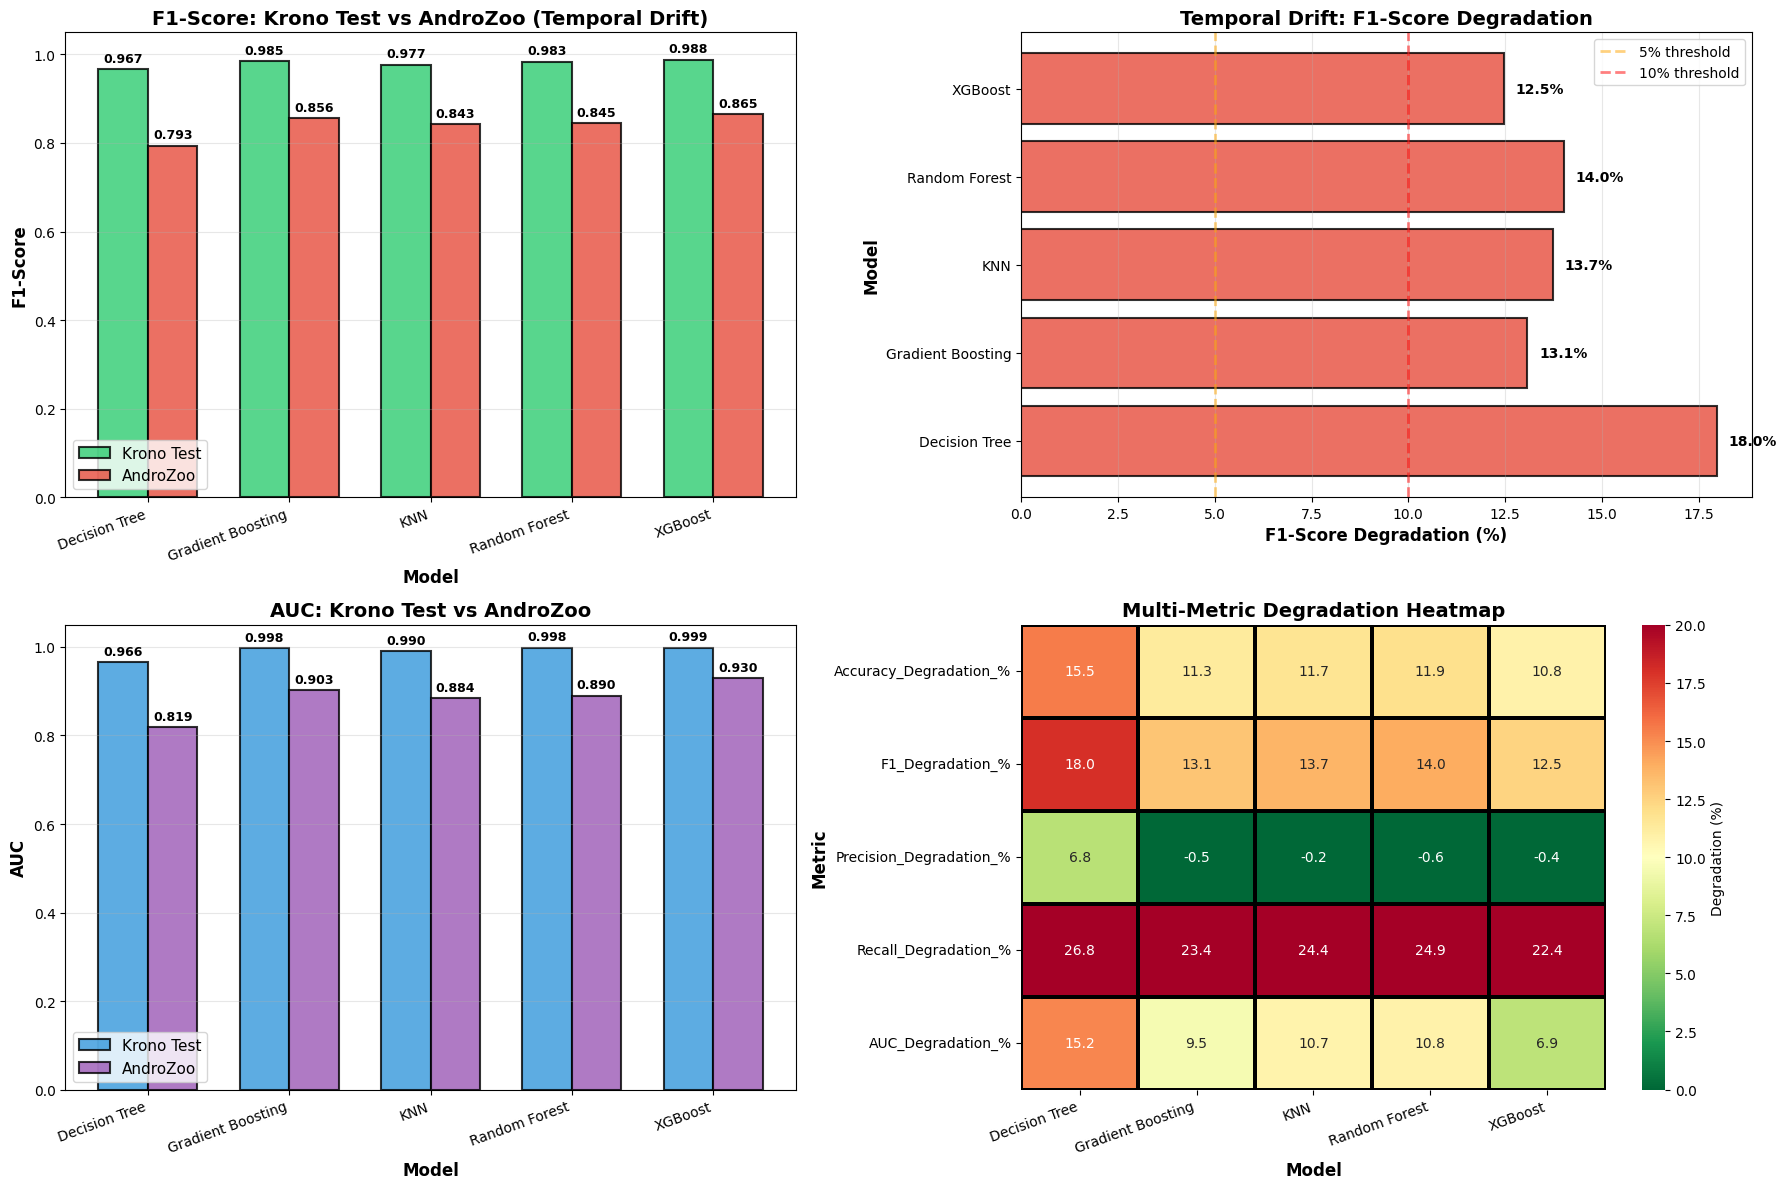

✅ Visualization saved: temporal_analysis_visualization.png

🎯 Creating confusion matrices for best model...


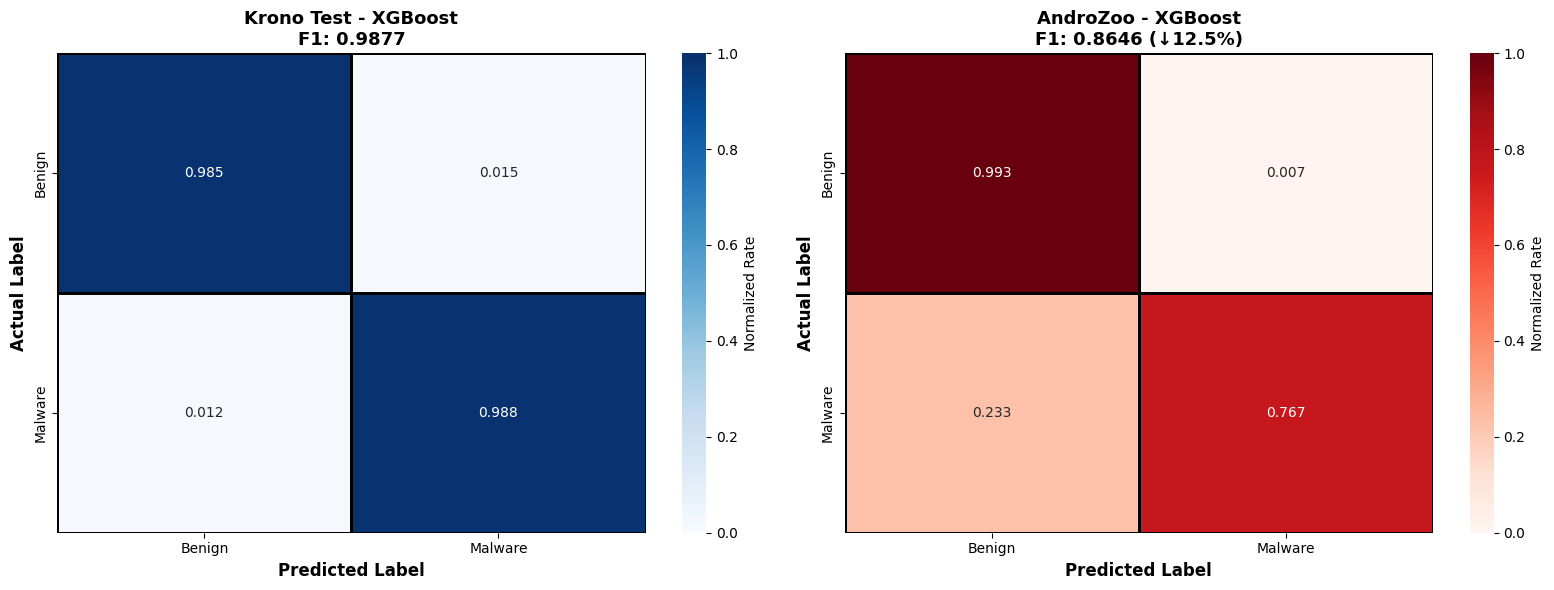

✅ Confusion matrices saved: temporal_confusion_matrices.png

PER-CLASS ANALYSIS - XGBoost

📊 KRONO TEST:
   Sensitivity (Malware Detection): 0.9882 (7231/7317)
   Specificity (Benign Detection):  0.9855 (6380/6474)
   False Positive Rate: 0.0145 (94 false alarms)
   False Negative Rate: 0.0118 (86 missed malware)

📊 ANDROZOO:
   Sensitivity (Malware Detection): 0.7670 (6903/9000)
   Specificity (Benign Detection):  0.9928 (8934/8999)
   False Positive Rate: 0.0072 (65 false alarms)
   False Negative Rate: 0.2330 (2097 missed malware)

📉 DEGRADATION:
   Sensitivity Degradation: 22.39%
   Specificity Degradation: -0.74%

📋 FINAL TEMPORAL ANALYSIS REPORT

🎯 EXPERIMENT SETUP:
   Training Dataset: Krono (Older malware samples)
   Training Samples: 55,164
   Validation Dataset: Krono Test (20% holdout)
   Validation Samples: 13,791
   Temporal Test Dataset: AndroZoo (Newer malware samples)
   Temporal Test Samples: 17,999

📊 OVERALL PERFORMANCE:
   Average F1 on Krono Test: 0.9799
   Average

In [13]:
# ============================================================================
# TEMPORAL ANALYSIS: KRONO → ANDROZOO INFERENCE
# ============================================================================
# Bu hücreleri mevcut notebook'unuzun sonuna ekleyin

# ============================================================================
# HÜCRE 1: AndroZoo Veri Yükleme ve Preprocessing
# ============================================================================
print("\n" + "="*90)
print("🕐 TEMPORAL ANALYSIS: AndroZoo Dataset Loading")
print("="*90)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# VERİ YÜKLEME
print("\n📁 Loading AndroZoo dataset...")
df_benign_androzoo = pd.read_csv('androzoo_benign.csv', low_memory=False)
df_malware_androzoo = pd.read_csv('androzoo_malware.csv', low_memory=False)

print(f"   Benign samples: {len(df_benign_androzoo):,}")
print(f"   Malware samples: {len(df_malware_androzoo):,}")

# Birleştir
df_androzoo = pd.concat([df_benign_androzoo, df_malware_androzoo], ignore_index=True)
print(f"   Total samples: {len(df_androzoo):,}")

# apk_name'i kaldır
if 'apk_name' in df_androzoo.columns:
    df_androzoo = df_androzoo.drop(columns=['apk_name'])

# ✅ LABEL'I DÜZELT
print("\n🔧 Fixing labels...")
print(f"   Original label values: {df_androzoo['label'].unique()}")

# Label'ı integer'a çevir - sayıya çevrilemeyenleri NaN yap
df_androzoo['label'] = pd.to_numeric(df_androzoo['label'], errors='coerce')

# Bozuk satırları sil (label=NaN olanlar)
df_androzoo = df_androzoo.dropna(subset=['label'])

# Label'ı integer yap
df_androzoo['label'] = df_androzoo['label'].astype(int)

print(f"   Fixed label values: {df_androzoo['label'].unique()}")
print(f"   Label distribution:")
print(df_androzoo['label'].value_counts())

# inf ve NaN temizliği
print("\n🧹 Cleaning data...")
df_androzoo = df_androzoo.replace([np.inf, -np.inf], np.nan)

# NaN'leri median ile doldur
for col in df_androzoo.columns:
    if col != 'label' and df_androzoo[col].dtype in ['float64', 'int64']:
        df_androzoo[col].fillna(df_androzoo[col].median(), inplace=True)

df_androzoo = df_androzoo.dropna()

print(f"   After cleaning: {len(df_androzoo):,} samples")

# X ve y ayır
X_androzoo = df_androzoo.drop(columns=['label'])
y_androzoo = df_androzoo['label']

# ⚠️ CRITICAL: Use the SAME scaler that was fitted on Krono training data
# The 'scaler' variable should already exist from previous cells (fitted on Krono X_train)
print("\n⚙️ Applying scaling (using Krono-fitted scaler)...")
X_androzoo_scaled = scaler.transform(X_androzoo)
X_androzoo_scaled = pd.DataFrame(X_androzoo_scaled, columns=X_androzoo.columns)

print("\n✅ AndroZoo Dataset Ready!")
print(f"   Samples: {X_androzoo_scaled.shape[0]:,}")
print(f"   Features: {X_androzoo_scaled.shape[1]}")
print(f"   Benign: {(y_androzoo==0).sum():,} ({(y_androzoo==0).sum()/len(y_androzoo)*100:.1f}%)")
print(f"   Malware: {(y_androzoo==1).sum():,} ({(y_androzoo==1).sum()/len(y_androzoo)*100:.1f}%)")
print("="*90)


# ============================================================================
# HÜCRE 2: Temporal Inference - All Optimized Models
# ============================================================================
print("\n" + "="*100)
print("🚀 TEMPORAL INFERENCE: Testing Krono-trained models on AndroZoo")
print("="*100)

# Optimized models dictionary (should exist from previous cells)
optimized_models_dict = {
    "Random Forest": optimized_rf,
    "XGBoost": optimized_xgb,
    "KNN": optimized_knn,
    "Decision Tree": optimized_dt,
    "Gradient Boosting": optimized_gb
}

# Store results
temporal_results = []

print(f"\n{'Model':<20} | {'Dataset':<15} | {'Acc':<7} | {'F1':<7} | {'Prec':<7} | {'Recall':<7} | {'AUC':<7}")
print("-"*100)

for model_name, model in optimized_models_dict.items():
    # ==========================================
    # 1. Performance on Krono Test Set (baseline)
    # ==========================================
    y_pred_krono = model.predict(X_test)
    
    # Probability scores (for AUC)
    try:
        if hasattr(model, 'predict_proba'):
            y_prob_krono = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):  # For SVM
            y_prob_krono = model.decision_function(X_test)
        else:
            y_prob_krono = None
    except:
        y_prob_krono = None
    
    # Metrics
    acc_krono = accuracy_score(y_test, y_pred_krono)
    f1_krono = f1_score(y_test, y_pred_krono)
    prec_krono = precision_score(y_test, y_pred_krono)
    rec_krono = recall_score(y_test, y_pred_krono)
    auc_krono = roc_auc_score(y_test, y_prob_krono) if y_prob_krono is not None else 0.0
    
    print(f"{model_name:<20} | {'Krono Test':<15} | {acc_krono:.5f} | {f1_krono:.5f} | {prec_krono:.5f} | {rec_krono:.5f} | {auc_krono:.5f}")
    
    temporal_results.append({
        "Model": model_name,
        "Dataset": "Krono Test",
        "Accuracy": acc_krono,
        "F1_Score": f1_krono,
        "Precision": prec_krono,
        "Recall": rec_krono,
        "AUC": auc_krono
    })
    
    # ==========================================
    # 2. Performance on AndroZoo (temporal drift test)
    # ==========================================
    y_pred_androzoo = model.predict(X_androzoo_scaled)
    
    # Probability scores
    try:
        if hasattr(model, 'predict_proba'):
            y_prob_androzoo = model.predict_proba(X_androzoo_scaled)[:, 1]
        elif hasattr(model, 'decision_function'):
            y_prob_androzoo = model.decision_function(X_androzoo_scaled)
        else:
            y_prob_androzoo = None
    except:
        y_prob_androzoo = None
    
    # Metrics
    acc_androzoo = accuracy_score(y_androzoo, y_pred_androzoo)
    f1_androzoo = f1_score(y_androzoo, y_pred_androzoo)
    prec_androzoo = precision_score(y_androzoo, y_pred_androzoo)
    rec_androzoo = recall_score(y_androzoo, y_pred_androzoo)
    auc_androzoo = roc_auc_score(y_androzoo, y_prob_androzoo) if y_prob_androzoo is not None else 0.0
    
    # Calculate degradation
    acc_deg = ((acc_krono - acc_androzoo) / acc_krono * 100) if acc_krono > 0 else 0
    f1_deg = ((f1_krono - f1_androzoo) / f1_krono * 100) if f1_krono > 0 else 0
    prec_deg = ((prec_krono - prec_androzoo) / prec_krono * 100) if prec_krono > 0 else 0
    rec_deg = ((rec_krono - rec_androzoo) / rec_krono * 100) if rec_krono > 0 else 0
    auc_deg = ((auc_krono - auc_androzoo) / auc_krono * 100) if auc_krono > 0 else 0
    
    print(f"{model_name:<20} | {'AndroZoo':<15} | {acc_androzoo:.5f} | {f1_androzoo:.5f} | {prec_androzoo:.5f} | {rec_androzoo:.5f} | {auc_androzoo:.5f}")
    print(f"{'':20} | {'Degradation':<15} | {acc_deg:>6.1f}% | {f1_deg:>6.1f}% | {prec_deg:>6.1f}% | {rec_deg:>6.1f}% | {auc_deg:>6.1f}%")
    print("-"*100)
    
    temporal_results.append({
        "Model": model_name,
        "Dataset": "AndroZoo",
        "Accuracy": acc_androzoo,
        "F1_Score": f1_androzoo,
        "Precision": prec_androzoo,
        "Recall": rec_androzoo,
        "AUC": auc_androzoo,
        "Accuracy_Degradation_%": acc_deg,
        "F1_Degradation_%": f1_deg,
        "Precision_Degradation_%": prec_deg,
        "Recall_Degradation_%": rec_deg,
        "AUC_Degradation_%": auc_deg
    })

print("="*100)

# Convert to DataFrame
temporal_df = pd.DataFrame(temporal_results)

# Display summary
print("\n📊 TEMPORAL ANALYSIS SUMMARY:")
print("="*100)

# Average degradation across all models
androzoo_results = temporal_df[temporal_df['Dataset'] == 'AndroZoo']
avg_f1_deg = androzoo_results['F1_Degradation_%'].mean()
avg_acc_deg = androzoo_results['Accuracy_Degradation_%'].mean()
avg_auc_deg = androzoo_results['AUC_Degradation_%'].mean()

print(f"   Average F1-Score Degradation: {avg_f1_deg:.2f}%")
print(f"   Average Accuracy Degradation: {avg_acc_deg:.2f}%")
print(f"   Average AUC Degradation: {avg_auc_deg:.2f}%")

# Best performing model on AndroZoo
best_model_androzoo = androzoo_results.sort_values('F1_Score', ascending=False).iloc[0]
print(f"\n🏆 Best Model on AndroZoo: {best_model_androzoo['Model']}")
print(f"   F1-Score: {best_model_androzoo['F1_Score']:.5f}")
print(f"   Accuracy: {best_model_androzoo['Accuracy']:.5f}")
print(f"   AUC: {best_model_androzoo['AUC']:.5f}")
print(f"   F1 Degradation: {best_model_androzoo['F1_Degradation_%']:.2f}%")

# Most robust model (least degradation)
most_robust = androzoo_results.sort_values('F1_Degradation_%', ascending=True).iloc[0]
print(f"\n💪 Most Robust Model (Least Degradation): {most_robust['Model']}")
print(f"   F1 Degradation: {most_robust['F1_Degradation_%']:.2f}%")
print(f"   AndroZoo F1-Score: {most_robust['F1_Score']:.5f}")

print("="*100)

# Save results
temporal_df.to_csv('temporal_analysis_results.csv', index=False)
print("\n💾 Results saved to: temporal_analysis_results.csv")


# ============================================================================
# HÜCRE 3: Visualization - Temporal Performance Comparison
# ============================================================================
print("\n📈 Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# --------------------------------------------------
# 1. F1-Score Comparison (Krono vs AndroZoo)
# --------------------------------------------------
krono_results = temporal_df[temporal_df['Dataset'] == 'Krono Test'].sort_values('Model')
androzoo_results = temporal_df[temporal_df['Dataset'] == 'AndroZoo'].sort_values('Model')

x_pos = np.arange(len(krono_results))
width = 0.35

bars1 = axes[0, 0].bar(x_pos - width/2, krono_results['F1_Score'].values, width,
                       label='Krono Test', color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = axes[0, 0].bar(x_pos + width/2, androzoo_results['F1_Score'].values, width,
                       label='AndroZoo', color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)

axes[0, 0].set_xlabel('Model', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('F1-Score', fontweight='bold', fontsize=12)
axes[0, 0].set_title('F1-Score: Krono Test vs AndroZoo (Temporal Drift)', 
                     fontweight='bold', fontsize=14)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(krono_results['Model'].values, rotation=20, ha='right')
axes[0, 0].legend(fontsize=11, loc='lower left')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1.05])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# --------------------------------------------------
# 2. F1-Score Degradation Percentage
# --------------------------------------------------
models = androzoo_results['Model'].values
f1_degradation = androzoo_results['F1_Degradation_%'].values

colors = ['#e74c3c' if x > 10 else '#f39c12' if x > 5 else '#2ecc71' for x in f1_degradation]

bars = axes[0, 1].barh(models, f1_degradation, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

axes[0, 1].set_xlabel('F1-Score Degradation (%)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Model', fontweight='bold', fontsize=12)
axes[0, 1].set_title('Temporal Drift: F1-Score Degradation', fontweight='bold', fontsize=14)
axes[0, 1].axvline(x=5, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='5% threshold')
axes[0, 1].axvline(x=10, color='red', linestyle='--', linewidth=2, alpha=0.5, label='10% threshold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, f1_degradation)):
    axes[0, 1].text(val + 0.3, bar.get_y() + bar.get_height()/2,
                    f'{val:.1f}%', ha='left', va='center', fontsize=10, fontweight='bold')

# --------------------------------------------------
# 3. AUC Comparison
# --------------------------------------------------
bars1 = axes[1, 0].bar(x_pos - width/2, krono_results['AUC'].values, width,
                       label='Krono Test', color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = axes[1, 0].bar(x_pos + width/2, androzoo_results['AUC'].values, width,
                       label='AndroZoo', color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=1.5)

axes[1, 0].set_xlabel('Model', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('AUC', fontweight='bold', fontsize=12)
axes[1, 0].set_title('AUC: Krono Test vs AndroZoo', fontweight='bold', fontsize=14)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(krono_results['Model'].values, rotation=20, ha='right')
axes[1, 0].legend(fontsize=11, loc='lower left')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# --------------------------------------------------
# 4. Multi-Metric Degradation Heatmap
# --------------------------------------------------
degradation_metrics = androzoo_results[['Model', 'Accuracy_Degradation_%', 
                                        'F1_Degradation_%', 'Precision_Degradation_%', 
                                        'Recall_Degradation_%', 'AUC_Degradation_%']].copy()

degradation_matrix = degradation_metrics.set_index('Model').T

sns.heatmap(degradation_matrix, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            ax=axes[1, 1], cbar_kws={'label': 'Degradation (%)'}, 
            vmin=0, vmax=20, linewidths=1.5, linecolor='black')

axes[1, 1].set_xlabel('Model', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Metric', fontweight='bold', fontsize=12)
axes[1, 1].set_title('Multi-Metric Degradation Heatmap', fontweight='bold', fontsize=14)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=20, ha='right')

plt.tight_layout()
plt.savefig('temporal_analysis_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: temporal_analysis_visualization.png")


# ============================================================================
# HÜCRE 4: Confusion Matrices - Best Model Comparison
# ============================================================================
print("\n🎯 Creating confusion matrices for best model...")

# Select best model (highest F1 on AndroZoo)
best_model_name = best_model_androzoo['Model']
best_model = optimized_models_dict[best_model_name]

# Predictions
y_pred_krono_best = best_model.predict(X_test)
y_pred_androzoo_best = best_model.predict(X_androzoo_scaled)

# Confusion matrices
cm_krono = confusion_matrix(y_test, y_pred_krono_best)
cm_androzoo = confusion_matrix(y_androzoo, y_pred_androzoo_best)

# Normalize by row (per-class perspective)
cm_krono_norm = cm_krono.astype('float') / cm_krono.sum(axis=1)[:, np.newaxis]
cm_androzoo_norm = cm_androzoo.astype('float') / cm_androzoo.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Krono Test
sns.heatmap(cm_krono_norm, annot=True, fmt='.3f', cmap='Blues', 
            xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'],
            ax=axes[0], cbar_kws={'label': 'Normalized Rate'}, 
            vmin=0, vmax=1, linewidths=2, linecolor='black')

axes[0].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_title(f'Krono Test - {best_model_name}\nF1: {krono_results[krono_results["Model"]==best_model_name]["F1_Score"].values[0]:.4f}', 
                  fontsize=13, fontweight='bold')

# AndroZoo
sns.heatmap(cm_androzoo_norm, annot=True, fmt='.3f', cmap='Reds', 
            xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'],
            ax=axes[1], cbar_kws={'label': 'Normalized Rate'}, 
            vmin=0, vmax=1, linewidths=2, linecolor='black')

axes[1].set_ylabel('Actual Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_title(f'AndroZoo - {best_model_name}\nF1: {best_model_androzoo["F1_Score"]:.4f} (↓{best_model_androzoo["F1_Degradation_%"]:.1f}%)', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('temporal_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Confusion matrices saved: temporal_confusion_matrices.png")

# Per-class metrics
tn_krono, fp_krono, fn_krono, tp_krono = cm_krono.ravel()
tn_andro, fp_andro, fn_andro, tp_andro = cm_androzoo.ravel()

print("\n" + "="*90)
print(f"PER-CLASS ANALYSIS - {best_model_name}")
print("="*90)

print(f"\n📊 KRONO TEST:")
print(f"   Sensitivity (Malware Detection): {tp_krono/(tp_krono+fn_krono):.4f} ({tp_krono}/{tp_krono+fn_krono})")
print(f"   Specificity (Benign Detection):  {tn_krono/(tn_krono+fp_krono):.4f} ({tn_krono}/{tn_krono+fp_krono})")
print(f"   False Positive Rate: {fp_krono/(fp_krono+tn_krono):.4f} ({fp_krono} false alarms)")
print(f"   False Negative Rate: {fn_krono/(fn_krono+tp_krono):.4f} ({fn_krono} missed malware)")

print(f"\n📊 ANDROZOO:")
print(f"   Sensitivity (Malware Detection): {tp_andro/(tp_andro+fn_andro):.4f} ({tp_andro}/{tp_andro+fn_andro})")
print(f"   Specificity (Benign Detection):  {tn_andro/(tn_andro+fp_andro):.4f} ({tn_andro}/{tn_andro+fp_andro})")
print(f"   False Positive Rate: {fp_andro/(fp_andro+tn_andro):.4f} ({fp_andro} false alarms)")
print(f"   False Negative Rate: {fn_andro/(fn_andro+tp_andro):.4f} ({fn_andro} missed malware)")

sens_deg = ((tp_krono/(tp_krono+fn_krono)) - (tp_andro/(tp_andro+fn_andro))) / (tp_krono/(tp_krono+fn_krono)) * 100
spec_deg = ((tn_krono/(tn_krono+fp_krono)) - (tn_andro/(tn_andro+fp_andro))) / (tn_krono/(tn_krono+fp_krono)) * 100

print(f"\n📉 DEGRADATION:")
print(f"   Sensitivity Degradation: {sens_deg:.2f}%")
print(f"   Specificity Degradation: {spec_deg:.2f}%")
print("="*90)


# ============================================================================
# HÜCRE 5: Final Summary Report
# ============================================================================
print("\n" + "="*90)
print("📋 FINAL TEMPORAL ANALYSIS REPORT")
print("="*90)

print(f"\n🎯 EXPERIMENT SETUP:")
print(f"   Training Dataset: Krono (Older malware samples)")
print(f"   Training Samples: {len(y_train):,}")
print(f"   Validation Dataset: Krono Test (20% holdout)")
print(f"   Validation Samples: {len(y_test):,}")
print(f"   Temporal Test Dataset: AndroZoo (Newer malware samples)")
print(f"   Temporal Test Samples: {len(y_androzoo):,}")

print(f"\n📊 OVERALL PERFORMANCE:")
print(f"   Average F1 on Krono Test: {temporal_df[temporal_df['Dataset']=='Krono Test']['F1_Score'].mean():.4f}")
print(f"   Average F1 on AndroZoo:   {temporal_df[temporal_df['Dataset']=='AndroZoo']['F1_Score'].mean():.4f}")
print(f"   Average F1 Degradation:   {avg_f1_deg:.2f}%")
print(f"   Average AUC Degradation:  {avg_auc_deg:.2f}%")

print(f"\n🏆 TOP 3 MODELS ON ANDROZOO:")
top3_androzoo = temporal_df[temporal_df['Dataset']=='AndroZoo'].sort_values('F1_Score', ascending=False).head(3)
for idx, row in top3_androzoo.iterrows():
    print(f"   {row['Model']:<20} F1: {row['F1_Score']:.4f}  |  Degradation: {row['F1_Degradation_%']:>5.1f}%")

print(f"\n💪 TOP 3 MOST ROBUST MODELS (Least Degradation):")
top3_robust = temporal_df[temporal_df['Dataset']=='AndroZoo'].sort_values('F1_Degradation_%', ascending=True).head(3)
for idx, row in top3_robust.iterrows():
    print(f"   {row['Model']:<20} Degradation: {row['F1_Degradation_%']:>5.1f}%  |  F1: {row['F1_Score']:.4f}")

print(f"\n⚠️ KEY FINDINGS:")
if avg_f1_deg < 5:
    print(f"   ✅ Models show EXCELLENT temporal robustness (< 5% degradation)")
elif avg_f1_deg < 10:
    print(f"   ⚠️ Models show MODERATE temporal drift (5-10% degradation)")
else:
    print(f"   ❌ Models show SIGNIFICANT temporal drift (> 10% degradation)")
    print(f"   → Consider: Regular retraining, ensemble methods, or domain adaptation")

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Best Overall Model: {best_model_androzoo['Model']} (F1: {best_model_androzoo['F1_Score']:.4f})")
print(f"   2. Most Robust Model: {most_robust['Model']} (Degradation: {most_robust['F1_Degradation_%']:.1f}%)")
if avg_f1_deg > 10:
    print(f"   3. ⚠️ High degradation detected - implement periodic retraining strategy")
    print(f"   4. Consider ensemble of top 3 models for improved robustness")

print("\n📁 OUTPUT FILES:")
print("   - temporal_analysis_results.csv")
print("   - temporal_analysis_visualization.png")
print("   - temporal_confusion_matrices.png")

print("\n" + "="*90)
print("✅ TEMPORAL ANALYSIS COMPLETE!")
print("="*90)